In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
REL_PATH_TO_NN_DATA = "./model_data.json"

In [4]:
with open(REL_PATH_TO_NN_DATA, 'r') as f:
    data = json.load(f)

In [5]:
weights_list = np.array(data.get("weights")).T
weights_list.shape

(10, 785)

In [6]:
weights_list

array([[ 80, 120, 114, ..., 120, 117, 113],
       [185, 119, 116, ..., 116, 113, 115],
       [131, 119, 114, ..., 120, 113, 117],
       ...,
       [212, 121, 115, ..., 115, 115, 121],
       [  0, 113, 113, ..., 120, 121, 121],
       [ 99, 118, 117, ..., 121, 120, 117]])

In [7]:
# reverse the weights again to fix the neuron order
weights_list = np.flip(weights_list, axis=0)

In [8]:
inputs_list = np.array(data.get("inputs"))
inputs_list.shape

(10000, 784)

In [9]:
input_bit_length = data["meta"]["inputs bitlength"]
print("Input Bit Length:", input_bit_length)

max_input_value = 2**input_bit_length - 1
print("Max Input Value:", max_input_value)

Input Bit Length: 3
Max Input Value: 7


In [10]:
def convert_to_storage_format(data: list, data_bit_length: int, storage_bit_length: int) -> np.array:
    numbers_per_address = storage_bit_length / data_bit_length
    
    if not numbers_per_address.is_integer():
        raise ValueError("Storage bit length not divisble by data bit length!")
    
    storage_data = []
    bit_string = ""
    for index, number in enumerate(data):
        bit_string += format(number, "b").zfill(data_bit_length)
        
        if (index+1) % numbers_per_address == 0:
            storage_data.append(bit_string) # add the bit-string to the storage data
            bit_string = "" # reset the bitstring
            continue
        
        if len(data) == (index + 1) and len(bit_string) != storage_bit_length:
            bit_string =bit_string.ljust(storage_bit_length, "0") # pad with zeroes to the right
            storage_data.append(bit_string) # add the bit-string to the storage data
            break
            
    return np.array(storage_data)

In [11]:
count = 0
for index, input in enumerate(inputs_list):
    label = data["label"][index]
    orig_result = data["predictions"]["original"][index]
    conv_result = data["predictions"]["converted"][index]
    if not label == conv_result:
        count += 1
        print(index, label, orig_result, conv_result)
        
print(count, count / 10_000)

8 5 6 6
33 4 6 6
38 2 3 3
63 3 2 2
66 6 3 2
124 7 4 4
149 2 9 9
193 9 3 3
217 6 5 5
233 8 7 7
241 9 3 3
245 3 5 5
247 4 2 2
259 6 0 0
290 8 4 4
313 3 3 5
318 2 3 3
320 9 7 7
321 2 7 7
340 5 3 3
344 8 5 5
352 5 0 0
359 9 4 4
362 2 7 7
381 3 7 7
391 8 8 5
403 8 5 5
412 5 3 3
435 8 7 7
445 6 0 0
448 9 8 8
469 5 8 8
478 5 8 8
479 9 3 3
495 8 8 0
502 5 3 3
507 3 5 5
528 3 2 2
531 3 6 6
536 2 1 1
542 8 2 2
543 8 3 3
551 7 1 1
565 4 9 9
569 3 5 5
578 3 2 2
582 8 1 1
583 2 8 8
591 8 3 3
606 8 3 3
613 2 8 8
629 2 6 6
659 2 9 7
684 7 3 3
691 8 4 4
692 5 7 7
707 4 9 9
714 8 8 5
717 0 6 6
720 5 8 2
740 4 9 9
760 4 9 9
781 8 5 5
786 6 5 5
791 5 9 9
800 8 8 5
829 4 8 8
839 8 3 3
844 8 7 7
857 5 3 3
874 9 4 4
877 8 2 2
879 8 8 5
881 4 9 9
882 9 7 7
898 7 2 2
924 2 7 7
938 3 3 5
939 2 0 0
947 8 9 9
950 7 2 2
956 1 3 3
965 6 0 0
975 2 3 3
999 9 7 7
1003 5 3 3
1014 6 5 5
1017 6 2 2
1028 3 5 5
1032 5 8 8
1033 8 3 3
1039 7 9 9
1044 6 2 2
1062 3 9 9
1068 8 4 4
1082 5 3 3
1101 8 3 3
1107 9 3 3
1112 4 6 6
11

In [51]:
TEST_INPUT_INDEX = 55

In [52]:
data["predictions"]["converted_raw"][TEST_INPUT_INDEX]

[86606, 77762, 82799, 82933, 81835, 84541, 81887, 80748, 84047, 82441]

In [53]:
data["predictions"]["converted"][TEST_INPUT_INDEX]

0

In [54]:
data["predictions"]["original"][TEST_INPUT_INDEX]

0

In [55]:
data["predictions"]["original_raw"][TEST_INPUT_INDEX]

[0.9970703125,
 0.0,
 9.5367431640625e-06,
 2.1398067474365234e-05,
 4.172325134277344e-07,
 0.001453399658203125,
 6.556510925292969e-07,
 0.0,
 0.000644683837890625,
 3.337860107421875e-06]

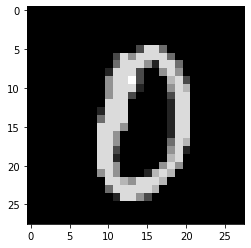

In [56]:
plt.imshow(
    inputs_list[TEST_INPUT_INDEX].reshape((28, 28)),
    cmap='gray'
)

In [57]:
# append a one at the start to include the bias multiplication (the inputs and weights are already reversed)
test_input = np.append([max_input_value], inputs_list[TEST_INPUT_INDEX])
test_input.shape

(785,)

In [58]:
input_storage_data = convert_to_storage_format(test_input[::-1], data_bit_length=3, storage_bit_length=12)
input_storage_data.shape

(197,)

In [59]:
weight_storage_data = []
for weights in weights_list:
    weight_storage_data.append(convert_to_storage_format(weights[::-1], data_bit_length=8, storage_bit_length=32))
    
weight_storage_data = np.ravel(np.array(weight_storage_data))
weight_storage_data.shape

(1970,)

### create the adresses for the weights

In [60]:
COUNT_OUTPUT_NEURONS = 10
COUNT_INPUT_MEMORY_ADRESSES = input_storage_data.shape[0]

In [61]:
NEURON_MEM_BIT_LENGTH = 4
INPUT_ADR_BIT_LENGTH = 8

weight_adresses = []

for neuron in range(0, COUNT_OUTPUT_NEURONS):
    for mem_adr in range(0, COUNT_INPUT_MEMORY_ADRESSES):
        neuron_bits = format(neuron, "b").zfill(NEURON_MEM_BIT_LENGTH)
        input_adr_bits = format(mem_adr, "b").zfill(INPUT_ADR_BIT_LENGTH)
        weight_adresses.append(int(neuron_bits + input_adr_bits, 2))

weight_adresses = np.array(weight_adresses)
weight_adresses

array([   0,    1,    2, ..., 2498, 2499, 2500])

In [71]:
def generate_vdhl_weight_array_allocation(filepath: str, adr: np.array, data: np.array, bit_len: int):
    with open(filepath, mode="w+") as file:

        # check the array format
        if not adr.shape[0] == data.shape[0]:
            raise ValueError("Shape of weight adresses and the weights itself must be the same!")

        max_adr = adr.max()
        adr = adr.tolist()
        for i in range(0, max_adr + 1):

            if i in adr:
                list_index = adr.index(i)
                output_str = f'"{data[list_index]}",\n'
            else:
                output_str = f'"{"".zfill(bit_len)}",\n'
            # print(f"{adr[i]} => {int(adr[i], 2)}")
            # output_str = f'{adr[i]} => "{data[i]}",\n'
            file.write(output_str)

### save the results

In [72]:
generate_vdhl_weight_array_allocation(
    filepath="./weights_array_generation.txt",
    adr=weight_adresses,
    data=weight_storage_data[::-1],
    bit_len=32
)

In [73]:
generate_vdhl_weight_array_allocation(
    filepath="./input_array_generated.txt",
    adr=np.array([i for i in range(0, 197)]),
    data=input_storage_data[::-1],
    bit_len=12
)